# Chatbot

Options :

In [1]:
train_model = True
#train_model = False

In [2]:
api = False
#api = True

In [3]:
test = False
#test = True

Importer les modules nécessaires :

In [4]:
import json
import pandas as pd
from nltk.stem.snowball import FrenchStemmer, EnglishStemmer
from nltk.corpus import stopwords 
from langdetect import detect
import unicodedata

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import random
import numpy as np

from keras.models import load_model

from flask import Flask, render_template, request

Obtenir la DataFrame à partir de ``content.json`` :

In [5]:
#ouvrir le fichier JSON
from connecteur import Connecteur
data1=Connecteur.get_all_data()

#créer les listes vides
tags = []
inputs = []
responses={}
#les remplir avec le contenu du JSON
for intent in data1['intents']:
  responses[intent['tag']]=intent['liste_output']
  for lines in intent['liste_input']:
    inputs.append(lines)
    tags.append(intent['tag'])
    
#convertir en DataFrame
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

#mélanger aléatoirement
data = data.sample(frac=1)

#montrer la DataFrame
display(data)
#montrer les catégories
data["tags"].value_counts()

{'intents': [{'tag': 'affirmation', 'liste_input': ['Oui', 'Yes', 'Ouais', 'Ok', 'Oui s’il vous plaît', 'd’accord'], 'liste_output': None}, {'tag': 'negation', 'liste_input': ['Non', 'Nan', 'Non merci', 'Nop', 'No'], 'liste_output': None}, {'tag': 'apprenant', 'liste_input': ['Apprenant', 'Élève', 'Je souhaite devenir apprenant', 'Je veux intégrer la formation', 'J’aimerai rejoindre l’école'], 'liste_output': ['Quelles informations recherchez-vous en tant que futur apprenant ?']}, {'tag': 'partenaire', 'liste_input': ['Partenaire', 'Entreprise', 'Je souhaite recruter des alternants', 'L’entreprise désire devenir partenaire de la formation'], 'liste_output': ['Quelle information recherchez-vous en tant que partenaire ?']}, {'tag': 'salutation', 'liste_input': ['Bonjour', 'Salut', 'J’aimerai des informations', 'Hello', 'De quoi peux-tu me parler ?', 'Que peux-tu me dire ?', 'Qu’est-ce que tu as à dire ?', 'Sur quels sujets peux-tu me renseigner ?', 'Bonjour, il y a quelqu’un ?'], 'liste_

,inputs,tags
13,Je souhaite devenir apprenant,apprenant
67,Pourquoi il y a des partenaires ?,alternance
26,Qu’est-ce que tu as à dire ?,salutation
71,Adios,fin
74,"Merci, bonne journée",fin
...,...,...
52,Y-a-t-il des cours par matières ?,pédagogie
70,Je m’en vais,fin
118,Que peux-t-on faire après ?,debouches
11,Apprenant,apprenant


admission          12
debouches          12
alternance         12
fin                 9
evaluation          9
salutation          9
pédagogie           8
aide financiere     6
affirmation         6
insultes            5
titre               5
negation            5
apprenant           5
covid               5
enseignants         5
code                4
partenaire          4
date                3
Name: tags, dtype: int64

Créer les fonctions de traitement du texte :

In [6]:
#enlever les accents du texte
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return str(only_ascii)[2:-1]

In [7]:
#définir les stopwords
stop_words_en = list(set(stopwords.words('english')))
stop_words_fr = list(set(stopwords.words('french')))

#rajouter aux stopwords français leurs versions sans accents
stop_words_fr_1 = []
for word in stop_words_fr:
    word = remove_accents(word)
    stop_words_fr_1.append(word)
stop_words_fr = list(sorted(set(stop_words_fr + stop_words_fr_1)))

In [8]:
#traiter le texte
def treatment(text):
    #vérifier si c'est une question
    if text[-1] == "?":
        question = "?"
    else:
        question = "0"
        
    #vérifier la langue
    if detect(text) == "fr":
        language = "francais"
    elif detect(text) == "en":
        language = "anglais"
    else:
        language = "francais"
    
    #segmenter le texte et traiter chaque mot et chaque lettre
    text = text.split()
    words_list = []
    for word in text:
        letters_list = []
        for character in word:
            #vérifier que le caractère est une lettre
            if character.isalpha():
                #rajouter à la liste en minuscule
                letters_list.append(character.lower())
            else:
                letters_list.append(" ")
        word = "".join(letters_list)
        
        #appliquer le stemming suivant la langue
        for word1 in word.split():
            word_yes = False
            if language == "anglais":
                if word1 not in stop_words_en:
                    word1 = EnglishStemmer().stem(word1)
                    word_yes = True
            else:
                if word1 not in stop_words_fr:
                    word1 = FrenchStemmer().stem(word1)
                    word_yes = True
            #enlever les accents
            if word_yes == True:
                word1 = remove_accents(word1)
                words_list.append(word1)
            
    #joindre en une string
    text = " ".join(words_list)
    return " ".join([text, question, language])
    #pour avoir en trois colonnes
    #return [text, question, language]

Obtenir une colonne avec les inputs traités :

In [9]:
#pour avoir en trois colonnes

#text_list = []
#ques_list = []
#lang_list = []

#for value in data["inputs"]:
    #value = treatment(value)
    #text_list.append(value[0])
    #ques_list.append(value[1])
    #lang_list.append(value[2])

#data["text"] = text_list
#data["?"] = ques_list
#data["language"] = lang_list

In [10]:
data["texts"] = data["inputs"].apply(treatment)

In [11]:
data

,inputs,tags,texts
13,Je souhaite devenir apprenant,apprenant,souhait deven appren 0 francais
67,Pourquoi il y a des partenaires ?,alternance,pourquoi partenair ? francais
26,Qu’est-ce que tu as à dire ?,salutation,dir ? francais
71,Adios,fin,adios 0 francais
74,"Merci, bonne journée",fin,merc bon journ 0 francais
...,...,...,...
52,Y-a-t-il des cours par matières ?,pédagogie,cour mati ? francais
70,Je m’en vais,fin,vais 0 francais
118,Que peux-t-on faire après ?,debouches,peux fair apres ? francais
11,Apprenant,apprenant,appren 0 francais


Appliquer le tokenizer sur les inputs traités :

In [12]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['texts'])
train = tokenizer.texts_to_sequences(data['texts'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

In [13]:
x_train

array([[  0,   0,   0, ...,  15,   2,   1],
       [  0,   0,   0, ...,  62,   7,   1],
       [  0,   0,   0, ...,   0,  35,   1],
       ...,
       [  0,   0,   0, ...,  19,   8,   1],
       [  0,   0,   0, ...,  15,   2,   1],
       [  0,   0,   0, ..., 163,   2,   1]])

Appliquer LabelEncoder() sur les tags :

In [14]:
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [15]:
input_shape = x_train.shape[1]
print(input_shape)

10


In [16]:
vocabulary = len(tokenizer.word_index)
print("Nombre de mots uniques : ",vocabulary)
output_length = le.classes_.shape[0]
print("Taille des outputs : ",output_length)

Nombre de mots uniques :  163
Taille des outputs :  18


Séparer ``x_train`` et ``y_train`` en ``train`` et ``val`` pour la validation :

In [17]:
#longueur d'1/5 du Dataset
prod=int(len(x_train)* 0.2)

#séparation en x_val et x_train
x_val=x_train[-prod:, :]
x_train=x_train[:-prod, :]

In [18]:
#séparation en y_val et y_train
y_val=y_train[ -prod:]
y_train=y_train[:-prod]

In [19]:
display(x_val.shape,x_train.shape,y_val.shape,y_train.shape)

(24, 10)

(100, 10)

(24,)

(100,)

Créer et entraîner le modèle :

In [20]:
if train_model == True:
    #créer le modèle
    i = Input(shape=(input_shape,))
    x = Embedding(vocabulary+1,10)(i)
    #x = LSTM(10,return_sequences=True)(x)
    x = Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10))(x)
    x = Bidirectional(LSTM(10))(x)
    x = Flatten()(x)
    x = Dense(output_length,activation="softmax")(x)
    model  = Model(i,x)

    #compiler le modèle
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

    #entraîner le modèle
    history = model.fit(x_train,y_train,epochs=300)
    
    #sauvegarder le modèle
    #model.save("chatbot.h5")

Epoch 1/300
4/4 [==============================] - 0s 21ms/step - loss: 2.8897 - accuracy: 0.0800
Epoch 2/300
4/4 [==============================] - 0s 21ms/step - loss: 2.8860 - accuracy: 0.0800
Epoch 3/300
4/4 [==============================] - 0s 20ms/step - loss: 2.8835 - accuracy: 0.1000
Epoch 4/300
4/4 [==============================] - 0s 19ms/step - loss: 2.8807 - accuracy: 0.1000
Epoch 5/300
4/4 [==============================] - 0s 19ms/step - loss: 2.8783 - accuracy: 0.1000
Epoch 6/300
4/4 [==============================] - 0s 18ms/step - loss: 2.8752 - accuracy: 0.1000
Epoch 7/300
4/4 [==============================] - 0s 20ms/step - loss: 2.8721 - accuracy: 0.1100
Epoch 8/300
4/4 [==============================] - 0s 19ms/step - loss: 2.8685 - accuracy: 0.1200
Epoch 9/300
4/4 [==============================] - 0s 19ms/step - loss: 2.8655 - accuracy: 0.1400
Epoch 10/300
4/4 [==============================] - 0s 22ms/step - loss: 2.8613 - accuracy: 0.1700
Epoch 11/300
4/4 [=

4/4 [==============================] - 0s 17ms/step - loss: 0.7925 - accuracy: 0.9100
Epoch 84/300
4/4 [==============================] - 0s 17ms/step - loss: 0.7774 - accuracy: 0.9200
Epoch 85/300
4/4 [==============================] - 0s 17ms/step - loss: 0.7501 - accuracy: 0.9200
Epoch 86/300
4/4 [==============================] - 0s 17ms/step - loss: 0.7375 - accuracy: 0.9200
Epoch 87/300
4/4 [==============================] - 0s 16ms/step - loss: 0.7210 - accuracy: 0.9100
Epoch 88/300
4/4 [==============================] - 0s 17ms/step - loss: 0.6901 - accuracy: 0.9200
Epoch 89/300
4/4 [==============================] - 0s 18ms/step - loss: 0.6755 - accuracy: 0.9300
Epoch 90/300
4/4 [==============================] - 0s 17ms/step - loss: 0.6542 - accuracy: 0.9400
Epoch 91/300
4/4 [==============================] - 0s 17ms/step - loss: 0.6426 - accuracy: 0.9600
Epoch 92/300
4/4 [==============================] - 0s 17ms/step - loss: 0.6280 - accuracy: 0.9200
Epoch 93/300
4/4 [=====

4/4 [==============================] - 0s 18ms/step - loss: 0.1989 - accuracy: 1.0000
Epoch 165/300
4/4 [==============================] - 0s 18ms/step - loss: 0.1951 - accuracy: 1.0000 0s - loss: 0.1951 - accuracy: 1.00
Epoch 166/300
4/4 [==============================] - 0s 19ms/step - loss: 0.1919 - accuracy: 1.0000
Epoch 167/300
4/4 [==============================] - 0s 17ms/step - loss: 0.1884 - accuracy: 1.0000
Epoch 168/300
4/4 [==============================] - 0s 19ms/step - loss: 0.1854 - accuracy: 1.0000
Epoch 169/300
4/4 [==============================] - 0s 20ms/step - loss: 0.1829 - accuracy: 1.0000
Epoch 170/300
4/4 [==============================] - 0s 18ms/step - loss: 0.1803 - accuracy: 1.0000
Epoch 171/300
4/4 [==============================] - 0s 18ms/step - loss: 0.1780 - accuracy: 1.0000
Epoch 172/300
4/4 [==============================] - 0s 18ms/step - loss: 0.1758 - accuracy: 1.0000
Epoch 173/300
4/4 [==============================] - 0s 18ms/step - loss: 0.173

4/4 [==============================] - 0s 22ms/step - loss: 0.0802 - accuracy: 1.0000
Epoch 246/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0799 - accuracy: 1.0000
Epoch 247/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0789 - accuracy: 1.0000
Epoch 248/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0782 - accuracy: 1.0000
Epoch 249/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0776 - accuracy: 1.0000
Epoch 250/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0773 - accuracy: 1.0000
Epoch 251/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0784 - accuracy: 1.0000
Epoch 252/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0767 - accuracy: 1.0000
Epoch 253/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0764 - accuracy: 1.0000
Epoch 254/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0754 - accuracy: 1.0000
Epoch 255/300


Faire une prédiction sur ``x_val`` :

In [21]:
#obtenir les arguments pour chaque ligne
y_pred=model.predict(x_val)

In [22]:
#récupérer l'argument maximal sur chaque ligne
y_pred_2 =[]
for pred in y_pred:
    y_pred_2.append(pred.argmax())
y_pred_2 = np.array(y_pred_2)
y_pred_2

array([ 8, 11,  4, 16, 15,  0, 13,  3, 11,  0,  3, 13, 11, 11, 17,  3,  7,
       16, 10, 16, 13,  8,  1, 13], dtype=int64)

faire une matrice de confusion pour comparer y_train de y_val

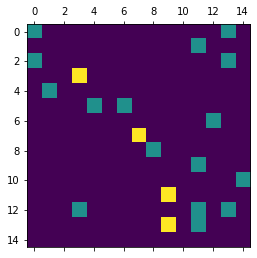

In [23]:
cm = confusion_matrix( y_val , y_pred_2)
plt.matshow(cm)

Il n'ya pas beaucoup de valeurs presente dans la matrice le modele ne contient pas assez de données.

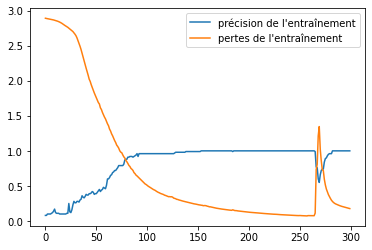

In [24]:
if train_model == True:
    #montrer l'historique de précision et des pertes
    plt.plot(history.history['accuracy'],label="précision de l'entraînement")
    plt.plot(history.history['loss'],label="pertes de l'entraînement")
    plt.legend()

In [ ]:
if train_model == False:
    model = load_model("chatbot.h5")

## Test

Taper 0 pour sortir.

In [ ]:
if test == True:
    while True:
      texts_p = []
      prediction_input = input('You : ')
      if prediction_input == "0":
        break

      #removing punctuation and converting to lowercase
      prediction_input = treatment(prediction_input)
      texts_p.append(prediction_input)
      print(prediction_input)

      #tokenizing and padding
      prediction_input = tokenizer.texts_to_sequences(texts_p)
      prediction_input = np.array(prediction_input).reshape(-1)
      prediction_input = pad_sequences([prediction_input],input_shape)
      print(prediction_input)

      #getting output from model
      output = model.predict(prediction_input)
      output = output.argmax()
      print(output)

      #finding the right tag and predicting
      response_tag = le.inverse_transform([output])[0]
      print(response_tag)
      #print("Going Merry : ",random.choice(responses[response_tag]))
      if response_tag == "goodbye":
        break

## API

In [ ]:
if api == True:
    app = Flask(__name__)

    s_list = ["inconnu", "apprenant", "partenaire"]
    user_status = s_list[0]

    #créer deux listes de tags identifiant l'utilisateur comme étant apprenant ou partenaire
    appr_list = []
    part_list = []

    #créer deux dictionnaires avec les équivalents d'output apprenant/partenaire
    to_appr = {}
    to_part = {}


    #definir les app.route
    @app.route("/")
    def index():
        return render_template("index.html")

    @app.route("/get")
    #fonction de réponse
    def get_bot_response():
        #obtenir la question et la formatter
        texts_p = []
        prediction_input = request.args.get('msg')
        prediction_input = treatment(prediction_input)
        texts_p.append(prediction_input)

        #formatter l'input
        prediction_input = tokenizer.texts_to_sequences(texts_p)
        prediction_input = np.array(prediction_input).reshape(-1)
        prediction_input = pad_sequences([prediction_input],input_shape)

        #prédire l'output
        output = model.predict(prediction_input)
        output = output.argmax()

        #vérifier si l'output identifie l'utilisateur
        if output in appr_list:
            user_status = s_list[1]
        elif output in part_list:
            user_status = s_list[2]

        #si l'utilisateur est identifié et l'output est susceptible de changer pour ça, alors le changer
        if user_status == s_list[1] and output in to_appr.keys():
            output = to_appr[output]
        elif user_status == s_list[2] and output in to_part.keys():
            output = to_part[output]

        #transformer la réponse et la renvoyer
        response_tag = le.inverse_transform([output])[0]
        response = str("Chatbot : ",random.choice(responses[response_tag]))
        return response

    #lancer l'API
    if __name__ == "__main__":
        app.run()